In [ ]:
# Step 1: Upload Files from Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 2: Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib


In [ ]:
# Step 3: Load the datasets

# Define file paths
training_data_path = '/content/drive/MyDrive/training_dataset.csv'
validation_data_path = '/content/drive/MyDrive/validation_dataset.csv'

# Load the datasets
training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)

# Check the first few rows of the datasets to ensure they are loaded correctly
print(training_data.head())
print(validation_data.head())

    PRODUCTION DATE Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE  \
0  07/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
1  08/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
2  09/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
3  10/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   
4  11/04/2014 00:00      DSEAT  DSEAT-001-F-1 C               105   

  WellBore Name   FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
0     001-F-1 C  production        OP                  0.00000   
1     001-F-1 C  production        OP                  0.00000   
2     001-F-1 C  production        OP                  0.00000   
3     001-F-1 C  production        OP                  0.00000   
4     001-F-1 C  production        OP               4500.45403   

   Downhole Temperature (Kelvin)  Average Tubing Pressure  \
0                      273.15000                  0.00000   
1                      273.15000                  0.00000   
2    

In [ ]:
# Step 4: Data Cleaning

# Convert 'PRODUCTION DATE' to datetime in both datasets
training_data['PRODUCTION DATE'] = pd.to_datetime(training_data['PRODUCTION DATE'], format='%d/%m/%Y %H:%M')
validation_data['PRODUCTION DATE'] = pd.to_datetime(validation_data['PRODUCTION DATE'], format='%Y-%m-%d %H:%M:%S')

# Handle missing values in 'Choke Size' by imputing with the median
training_data['Choke Size'].fillna(training_data['Choke Size'].median(), inplace=True)
validation_data['Choke Size'].fillna(validation_data['Choke Size'].median(), inplace=True)

# Correct inconsistent data entries - Adjust column names if needed
# Assume 'Pressure' column has negative values which are invalid
training_data = training_data[(training_data['Downhole Pressure (PSI)'] >= 0) &
                              (training_data['Average Tubing Pressure'] >= 0) &
                              (training_data['Annulus Pressure (PSI)'] >= 0) ]

validation_data = validation_data[(validation_data['Downhole Pressure (PSI)'] >= 0) &
                                  (validation_data['Average Tubing Pressure'] >= 0) &
                                  (validation_data['Annulus Pressure (PSI)'] >= 0) ]

# Remove redundant columns if any

In [ ]:
# Step 5: Data Preprocessing

# Extract date-related features
for dataset in [training_data, validation_data]:
    dataset['Year'] = dataset['PRODUCTION DATE'].dt.year
    dataset['Month'] = dataset['PRODUCTION DATE'].dt.month
    dataset['Day'] = dataset['PRODUCTION DATE'].dt.day
    dataset['DayOfWeek'] = dataset['PRODUCTION DATE'].dt.dayofweek

# Drop the original date column
training_data.drop('PRODUCTION DATE', axis=1, inplace=True)
validation_data.drop('PRODUCTION DATE', axis=1, inplace=True)


       N_WELL_BORE_CODE  Downhole Pressure (PSI)  \
count       6925.000000              6925.000000   
mean         107.297040              2587.482923   
std            0.980161              1588.474034   
min          105.000000                 0.000000   
25%          107.000000                 0.000000   
50%          107.000000              3378.397358   
75%          108.000000              3664.905359   
max          109.000000              4606.666675   

       Downhole Temperature (Kelvin)  Average Tubing Pressure  \
count                    6925.000000              6925.000000   
mean                      349.674794              2161.986343   
std                        46.240823              1053.875029   
min                       273.150000                 0.000000   
25%                       273.150000               896.612291   
50%                       376.911370              2472.031527   
75%                       379.496193              2907.047474   
max        

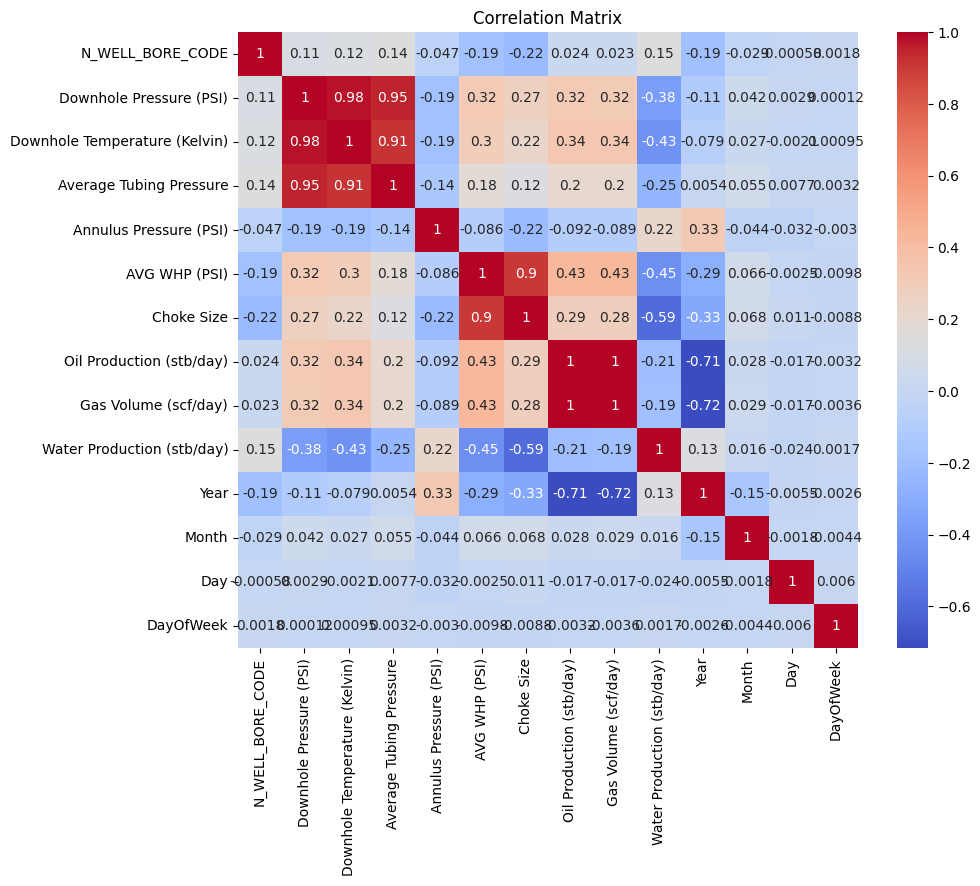

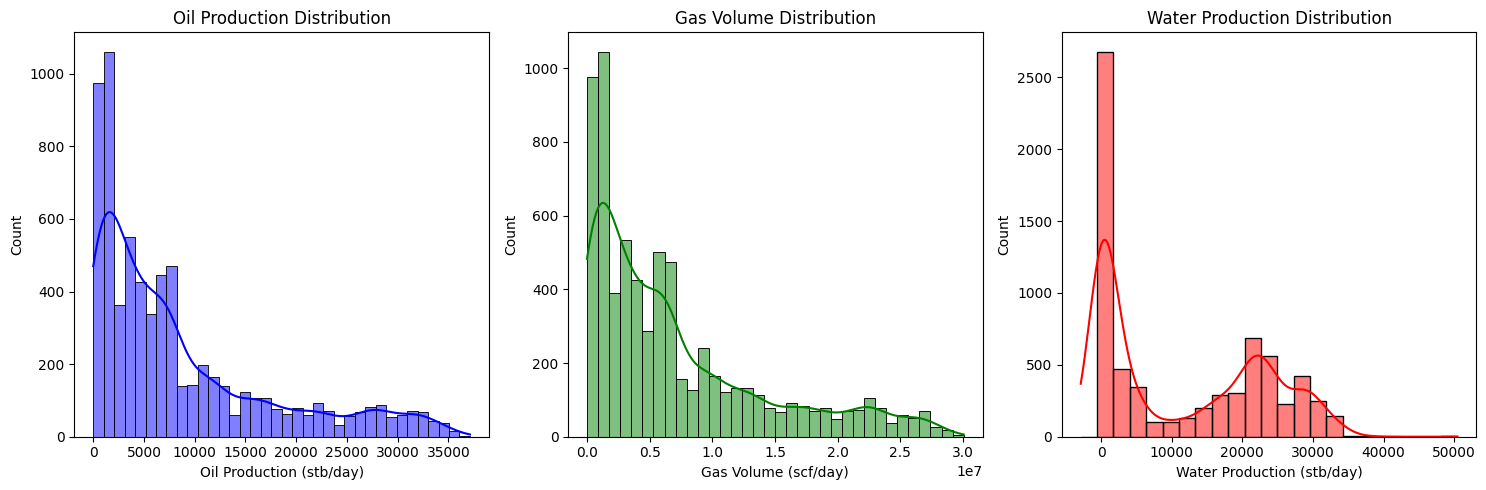

In [ ]:
# Step : Data Exploration and Analysis

# Summary statistics
print(training_data.describe())

# Drop non-numeric columns before calculating correlation
numeric_data = training_data.select_dtypes(include=['number'])

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Distribution of target variables
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(training_data['Oil Production (stb/day)'], kde=True, color='blue')
plt.title('Oil Production Distribution')

plt.subplot(1, 3, 2)
sns.histplot(training_data['Gas Volume (scf/day)'], kde=True, color='green')
plt.title('Gas Volume Distribution')

plt.subplot(1, 3, 3)
sns.histplot(training_data['Water Production (stb/day)'], kde=True, color='red')
plt.title('Water Production Distribution')

plt.tight_layout()
plt.show()


In [ ]:
# Step 6: Feature Engineering

training_data['Choke_Size_Squared'] = training_data['Choke Size'] ** 2
validation_data['Choke_Size_Squared'] = validation_data['Choke Size'] ** 2

# Define features and target variables
features = training_data.drop(columns=['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'])
targets = training_data[['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)']]

X_train, X_val, y_train, y_val = train_test_split(features, targets, test_size=0.2, random_state=42)

# Define preprocessing pipeline
numeric_features = ['Choke Size', 'Year', 'Month', 'Day', 'DayOfWeek', 'Choke_Size_Squared']
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])


In [ ]:
# Step 7: Model Selection and Training (Gradient Boosting Regression)

# Train separate models for each target
target_columns = ['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)']
models = {}

for target in target_columns:
    # Define the model pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', GradientBoostingRegressor(random_state=42))])

    # Define the parameter grid for Grid Search
    param_grid = {'model__n_estimators': [50, 100, 200],
                  'model__learning_rate': [0.01, 0.1, 0.2],
                  'model__max_depth': [3, 5, 7]}

    # Perform Grid Search with Cross-Validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')

    # Extract the target variable for training
    y_train_single = y_train[target]

    grid_search.fit(X_train, y_train_single)  # Fit on single target

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    models[target] = grid_search  # Store the trained model

# Define the model pipeline
#pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', GradientBoostingRegressor(random_state=42))])

# Define the parameter grid for Grid Search
#param_grid = {'model__n_estimators': [50, 100, 200], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [3, 5, 7]}

# Perform Grid Search with Cross-Validation
#grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
#grid_search.fit(X_train, y_train)

#print(f"Best parameters found: {grid_search.best_params_}")


Best parameters for Oil Production (stb/day): {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Best parameters for Gas Volume (scf/day): {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Best parameters for Water Production (stb/day): {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100}


In [ ]:
# Step 8: Model Evaluation

# Evaluate models for each target
for target in target_columns:
    best_model = models[target].best_estimator_
    y_pred_val = best_model.predict(X_val)

    # Extract the corresponding true values for the current target
    y_val_single = y_val[target]

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_val_single, y_pred_val)
    mse = mean_squared_error(y_val_single, y_pred_val)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val_single, y_pred_val)
    mape = np.mean(np.abs((y_val_single - y_pred_val) / y_val_single)) * 100

    # Print evaluation metrics
    print(f'Metrics for {target}:')
    print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}, R²: {r2}, MAPE: {mape}%')

Metrics for Oil Production (stb/day):
MAE: 1418.9150156578714, MSE: 7917581.454853865, RMSE: 2813.81972678668, R²: 0.900301660554565, MAPE: inf%
Metrics for Gas Volume (scf/day):
MAE: 1169043.2684741553, MSE: 5384811239826.956, RMSE: 2320519.605568321, R²: 0.892347847822716, MAPE: inf%
Metrics for Water Production (stb/day):
MAE: 1833.3486242994027, MSE: 12756020.709579824, RMSE: 3571.5571827397393, R²: 0.9040967939152942, MAPE: inf%


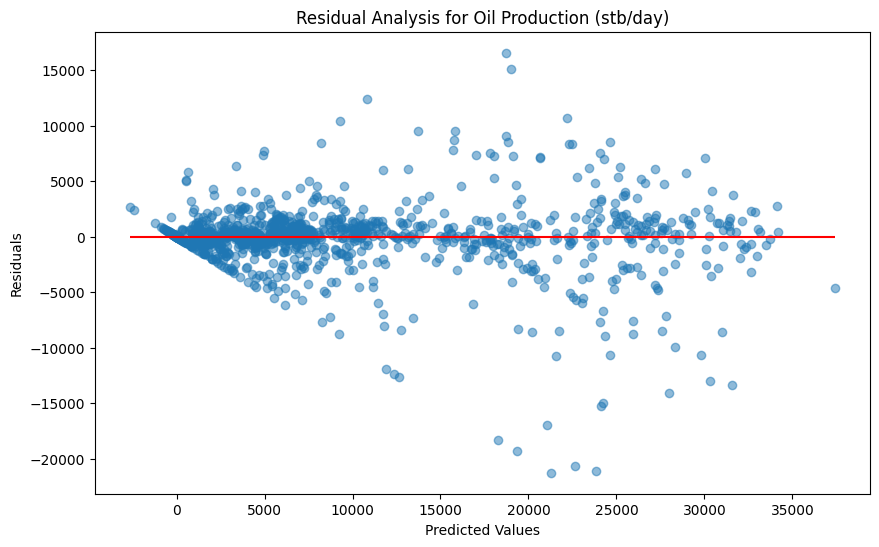

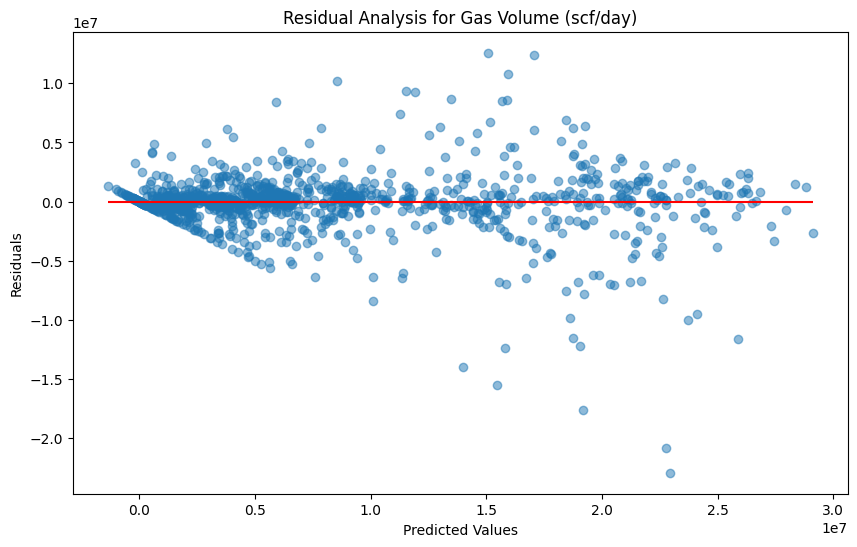

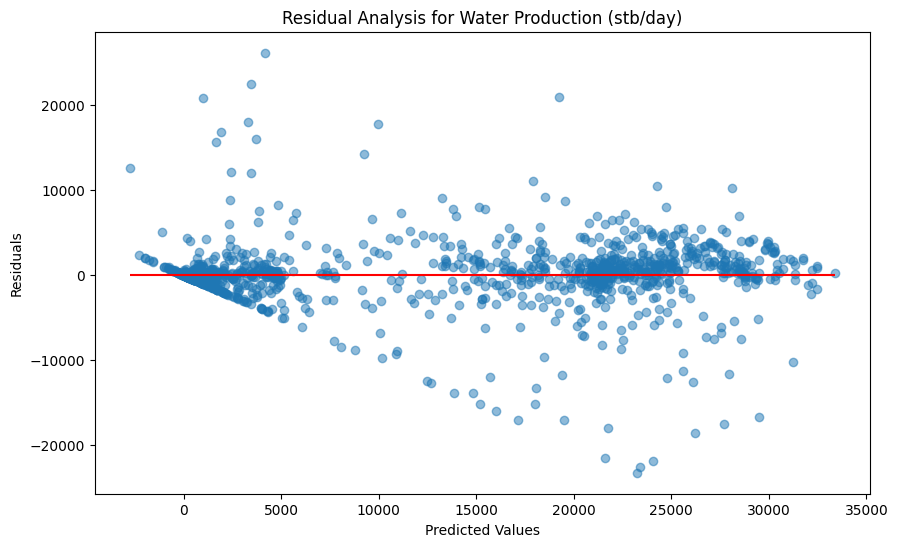

In [ ]:
# Step 9: Residual Analysis

# Create a dictionary to store residuals for each target
residuals = {}

for target in target_columns:
    # Extract predictions for the current target
    y_pred_val_single = models[target].best_estimator_.predict(X_val)

    # Extract true values for the current target
    y_val_single = y_val[target]

    # Calculate residuals for the current target
    residuals[target] = y_val_single - y_pred_val_single

    # Plot residual analysis for the current target
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_val_single, residuals[target], alpha=0.5)
    plt.hlines(y=0, xmin=min(y_pred_val_single), xmax=max(y_pred_val_single), colors='r')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Analysis for {target}')
    plt.show()

In [ ]:
# Step 10: Model Testing

# Evaluate the final model on validation dataset
validation_features = validation_data.drop(columns=['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'], errors='ignore')
validation_features['Choke_Size_Squared'] = validation_features['Choke Size'] ** 2

# Predict for each target and store in a list
validation_predictions_list = []
for target in target_columns:
    best_model = models[target].best_estimator_  # Get the best model for the current target
    validation_predictions_list.append(best_model.predict(validation_features))

# Concatenate predictions for all targets
validation_predictions = np.column_stack(validation_predictions_list)

# Calculate cumulative production
validation_predictions_df = pd.DataFrame(validation_predictions, columns=['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'])

total_oil_production = validation_predictions_df['Oil Production (stb/day)'].sum()
total_gas_volume = validation_predictions_df['Gas Volume (scf/day)'].sum()
total_water_production = validation_predictions_df['Water Production (stb/day)'].sum()

print(f'Total Oil Production: {total_oil_production} stb')
print(f'Total Gas Volume: {total_gas_volume} scf')
print(f'Total Water Production: {total_water_production} stb')

Total Oil Production: 3385599.699270234 stb
Total Gas Volume: 2843403942.255766 scf
Total Water Production: 9953840.279315278 stb
